# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import json
import numpy as np
from glob import glob
from os.path import basename, join, dirname, isfile

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm)

In [2]:
dset_file = '/Users/tsalo/Documents/tsalo/NiMARE/nimare/tests/data/nidm_pain_dset.json'
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()

mask = join(nimare.utils.get_resource_path(),
            'templates/MNI152_2mm_mask.nii.gz')
mask_img = nib.load(mask)

logp_thresh = -np.log(.05)

## Define functions for querying set of NIDM-Results packs

In [3]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type 
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)
            
        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files


## Get z-maps

In [4]:
files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(f) for f in files[0]]
z_data = apply_mask(z_imgs, mask_img)

## Fisher's

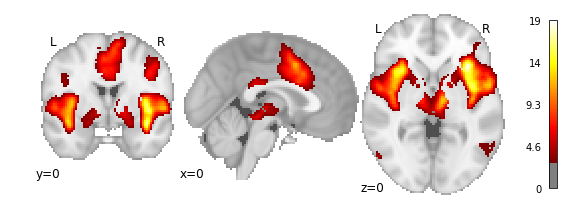

In [5]:
result = fishers(z_data, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

## Stouffer's

### Fixed-effects inference

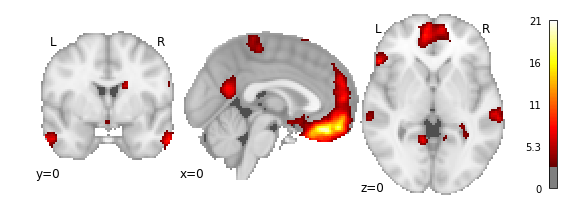

In [6]:
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

### Random-effects inference with theoretical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


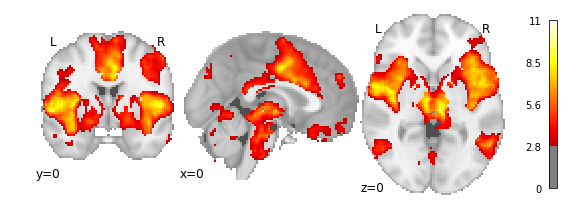

In [7]:
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

### Random-effects inference with empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


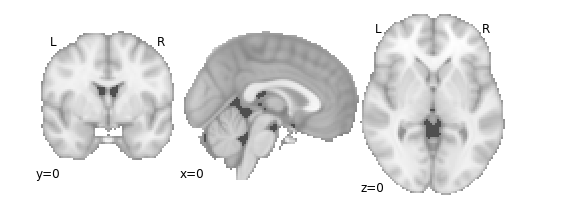

In [8]:
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

## Get z-maps + sample sizes

In [9]:
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(f) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)
sample_sizes = np.array(ns)

## Weighted Stouffer's

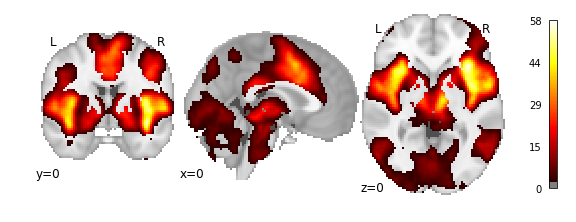

In [10]:
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

## Get contrast maps + contrast standard error maps + sample sizes

In [11]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(f) for f in con_files]
se_imgs = [nib.load(f) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)

## FFX GLM

/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/ibma/ibma.py:359: RuntimeWarning: invalid value encountered in true_divide
  ffx_stat_map = adj_con_map / np.sqrt(est_ss_map)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/ibma/ibma.py:365: RuntimeWarning: divide by zero encountered in log10
  log_p_map = -np.log10(p_map)


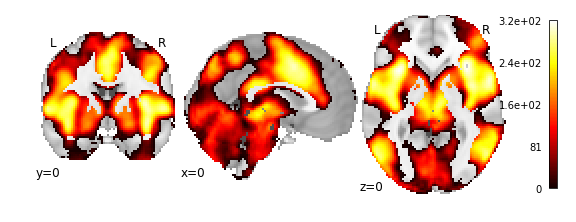

In [12]:
result = ffx_glm(con_data, se_data, sample_sizes, mask_img,
                 equal_var=True)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

## Get contrast maps

In [13]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(f) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)

## RFX GLM

### Theoretical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


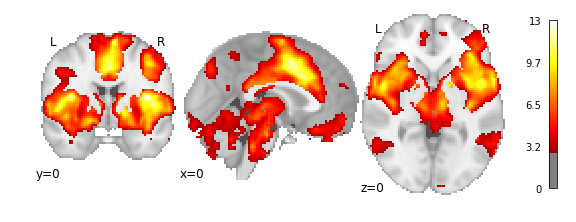

In [14]:
result = rfx_glm(con_data, mask_img, null='theoretical',
                 n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

### Empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/ibma/ibma.py:296: RuntimeWarning: divide by zero encountered in log10
  log_p_map = -np.log10(p_map)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


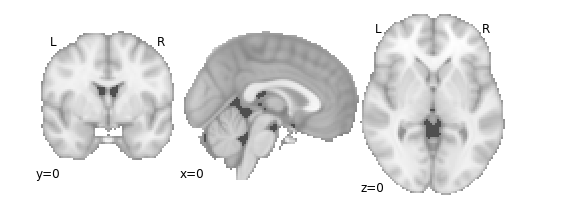

In [15]:
result = rfx_glm(con_data, mask_img, null='empirical',
                 n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, 0], draw_cross=False)

## MKDA

/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:68: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:72: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * prior / pAgF_prior


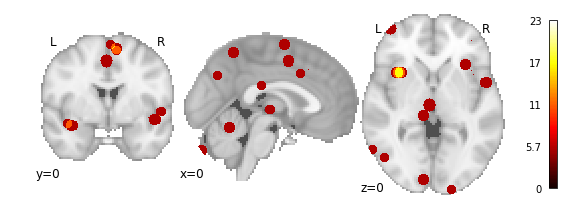

In [16]:
mkda = nimare.meta.cbma.MKDA(dset, ids=dset.ids, ids2=dset.ids, kernel__r=6)
mkda.fit()
plot_stat_map(mkda.images['pAgF_z_FDR_0.05'],
              cut_coords=[0, 0, 0], draw_cross=False)